# Movie/Series french review satisfaction prediction

## Importation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import keras
import tqdm

from data_science import prexplo, utils
from custom_nlp import TFIDFTransformer
from mygenerator import MyRange

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hany\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Hany\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Reading data

In [2]:
data = pd.read_csv('allocine_reviews.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
print(data.shape)
data.head()

(10189, 3)


,movie_series_name,review_note,review_text
0,Top Gun: Maverick,5.0,\nEnfin un film qui sort du lot .. même si cer...
1,Top Gun: Maverick,5.0,\nIl n'y a pas assez d'étoiles pour qualifier ...
2,Top Gun: Maverick,4.5,\nLa suite d'un classique a créé un autre clas...
3,Top Gun: Maverick,4.5,\nRares sont les bonnes suites. Alors imaginez...
4,Top Gun: Maverick,4.0,"\nDès les premières secondes, la nostalgie du ..."


In [4]:
prexplo.describe_columns(data)

,Type,NaN count,NaN frequency,Number of unique values
movie_series_name,object,0,0.0,11
review_note,float64,0,0.0,10
review_text,object,0,0.0,10165


Text(0, 0.5, 'Occurences')

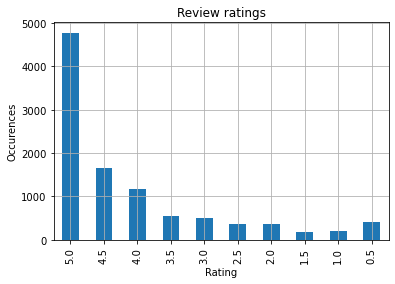

In [5]:
plt.figure()
data['review_note'].value_counts().sort_index(ascending=False).plot.bar()
plt.grid(True)
plt.title('Review ratings')
plt.xlabel('Rating')
plt.ylabel('Occurences')

## Preprocessing

In [6]:
df = data.copy()

In [7]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)

y_train = (df_train['review_note'] >= 2.5).astype('int').values
y_test = (df_test['review_note'] >= 2.5).astype('int').values

tfidf_transformer = TFIDFTransformer()
tfidf_transformer.fit(df_train['review_text'].values)

x_train = tfidf_transformer.transform(df_train['review_text'].values)
x_test = tfidf_transformer.transform(df_test['review_text'].values)

print('Train shape:', x_train.shape)
print('Test shape:', x_test.shape)

Train shape: (8151, 24537)
Test shape: (2038, 24537)


## Modelisation

In [8]:
model = keras.Sequential()

model.add(keras.layers.Input(shape=(x_train.shape[-1],)))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.Recall()])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               3140864   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 3,140,993
Trainable params: 3,140,993
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.fit(x_train, y_train, batch_size=64, epochs=5)

Epoch 1/5
128/128 [==============================] - 3s 26ms/step - loss: 0.3946 - recall: 0.9945
Epoch 2/5
128/128 [==============================] - 4s 29ms/step - loss: 0.2298 - recall: 0.9997
Epoch 3/5
128/128 [==============================] - 4s 29ms/step - loss: 0.1318 - recall: 0.9972
Epoch 4/5
128/128 [==============================] - 3s 23ms/step - loss: 0.0694 - recall: 0.9970
Epoch 5/5
128/128 [==============================] - 3s 23ms/step - loss: 0.0387 - recall: 0.9985


In [10]:
tresholds = MyRange(0.1, 1, 0.1)

train_acc = []
test_acc = []
train_prec = []
test_prec = []
train_rec = []
test_rec = []
train_f1 = []
test_f1 = []


for t in tqdm.tqdm(tresholds):
    y_train_pred = (model.predict(x_train) > t).astype('int')
    y_test_pred = (model.predict(x_test) > t).astype('int')
    
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))
    
    train_prec.append(precision_score(y_train, y_train_pred))
    test_prec.append(precision_score(y_test, y_test_pred))
    
    train_rec.append(recall_score(y_train, y_train_pred))
    test_rec.append(recall_score(y_test, y_test_pred))
    
    train_f1.append(f1_score(y_train, y_train_pred))
    test_f1.append(f1_score(y_test, y_test_pred))

100%|██████████| 9/9 [00:27<00:00,  3.06s/it]


## Evaluation

Text(0.5, 1.0, 'Score evolution with different decision tresholds.')

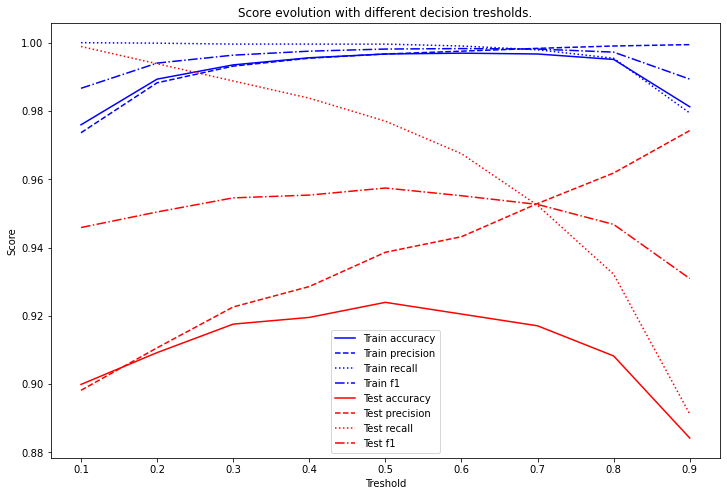

In [11]:
plt.figure(figsize=(12, 8))

#'-', '--', '-.', ':', ''

plt.plot(tresholds, train_acc, label='Train accuracy', c='b', linestyle='-')
plt.plot(tresholds, train_prec, label='Train precision', c='b', linestyle='--')
plt.plot(tresholds, train_rec, label='Train recall', c='b', linestyle=':')
plt.plot(tresholds, train_f1, label='Train f1', c='b', linestyle='-.')

plt.plot(tresholds, test_acc, label='Test accuracy', c='r', linestyle='-')
plt.plot(tresholds, test_prec, label='Test precision', c='r', linestyle='--')
plt.plot(tresholds, test_rec, label='Test recall', c='r', linestyle=':')
plt.plot(tresholds, test_f1, label='Test f1', c='r', linestyle='-.')

plt.xlabel('Treshold')
plt.ylabel('Score')
plt.legend()

plt.title('Score evolution with different decision tresholds.')

### Train

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       916
           1       1.00      1.00      1.00      7235

    accuracy                           1.00      8151
   macro avg       0.99      0.99      0.99      8151
weighted avg       1.00      1.00      1.00      8151



<AxesSubplot:>

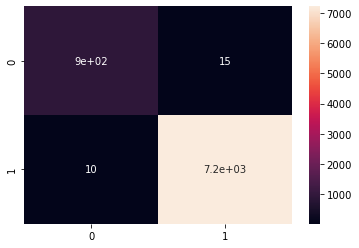

In [12]:
final_treshold = 0.65

y_train_pred = (model.predict(x_train) >= final_treshold).astype('int')

print(classification_report(y_train, y_train_pred))
sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True)

### Test

              precision    recall  f1-score   support

           0       0.69      0.64      0.66       254
           1       0.95      0.96      0.95      1784

    accuracy                           0.92      2038
   macro avg       0.82      0.80      0.81      2038
weighted avg       0.92      0.92      0.92      2038



<AxesSubplot:>

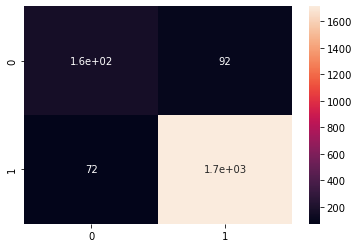

In [13]:
y_test_pred = (model.predict(x_test) >= final_treshold).astype('int')

print(classification_report(y_test, y_test_pred))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True)

In [14]:
model.save('base_model.h5')

utils.save_model(tfidf_transformer, 'tfidf_transformer.pkl')

## Example test

In [15]:
good_review_text = """Ce film est incroyable! Le jeu d'acteur est sans égal,
                    je suis resté scotché sur mon siège tout le long du film!
                    Enfin bref le film est un chef-d'oeuvre absolue! Je le recommande vivement."""


bad_review_text = """Je n'ai jamais vu une bouse pareille. Le scénario est complètement incohérent, rien ne vas!!
                On aurai coupé le film en deux que je m'ennuierais toujours. J'ai l'impression que même les acteurs voulaient
                s'échapper du film. Si vous voulez ne pas perdre une heure et demi de votre vie, passez votre chemin."""

In [16]:
x_examples = tfidf_transformer.transform([good_review_text, bad_review_text])

model.predict(x_examples)

array([[0.9968579 ],
       [0.04222924]], dtype=float32)